In [ ]:
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/vae
%ls

Mounted at /content/drive
/content/drive/MyDrive/vae
vae/


In [ ]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

# Specify the target size for resizing
target_size = (224, 224)

def load_data(data_path):
    # Initialize the lists to store images and labels
    X_data = []  # List for images
    y_data = []  # List for labels

    # Loop through emotion folders in data
    for label, emotion in enumerate(os.listdir(data_path)):
        emotion_path = os.path.join(data_path, emotion)

        if os.path.isdir(emotion_path):
            for filename in os.listdir(emotion_path):
                image_path = os.path.join(emotion_path, filename)
                if os.path.isfile(image_path):
                    # Read the image in color
                    img = cv2.imread(image_path)
                    # image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)


                    # Resize the image to the target size
                    img = cv2.resize(img, target_size)

                    # Append the resized image to X_data
                    X_data.append(img)

                    # Append the label to y_data
                    y_data.append(label)

    # Shuffle the data (X_data and y_data)
    X_data, y_data = shuffle(X_data, y_data)

    # Convert X_data and y_data to NumPy arrays
    X_data = np.array(X_data)
    y_data = np.array(y_data)

    return X_data, y_data

def augment_data(X_train):
    # Create an instance of ImageDataGenerator
    datagen = ImageDataGenerator(
        rotation_range=20,  # Rotate images randomly by 20 degrees
        width_shift_range=0.2,  # Shift images horizontally by 20% of the width
        height_shift_range=0.2,  # Shift images vertically by 20% of the height
        shear_range=0.2,  # Apply shear transformation with a range of 20 degrees
        zoom_range=0.2,  # Zoom in or out on images by 20%
        horizontal_flip=True,  # Flip images horizontally
        fill_mode='nearest'  # Fill any newly created pixels after rotation or shifting
    )

    # Generate augmented images
    augmented_images = []
    for image in X_train:
        augmented_image = datagen.random_transform(image)
        augmented_images.append(augmented_image)

    augmented_images = np.array(augmented_images)

    return augmented_images

# Path to your data folder
data_path = "/content/drive/MyDrive/Variational Auto Encoder"

# Load all available data
X, y = load_data(data_path)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform data augmentation on the training set
X_train_augmented = augment_data(X_train)

# Concatenate the augmented training set with the original training set
X_train_combined = np.concatenate((X_train, X_train_augmented), axis=0)
y_train_combined = np.concatenate((y_train, y_train), axis=0)

# Shuffle the combined training data
X_train_combined, y_train_combined = shuffle(X_train_combined, y_train_combined)

# Normalize the images
X_train = X_train_combined.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

# Print the shapes of the datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train_combined.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (354, 224, 224, 3)
y_train shape: (354,)
X_test shape: (45, 224, 224, 3)
y_test shape: (45,)


In [ ]:
len(np.unique(y_train_combined))

2

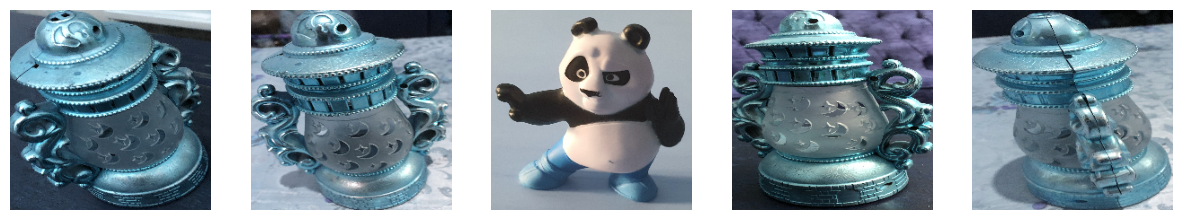

In [ ]:
import matplotlib.pyplot as plt



num_images = 5

plt.figure(figsize=(15, 5))

for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(X_test[i])
    plt.axis('off')  # Turn off axis labels for cleaner display

plt.show()


# VAE

In [ ]:
import keras
from keras import layers
import numpy as np

# Define the input shape for colored images
original_dim = 224 * 224 * 3
intermediate_dim = 500  # Adjust based on your preferences
latent_dim = 30

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = keras.backend.random_normal(shape=(keras.backend.shape(z_mean)[0], latent_dim),
                                          mean=0., stddev=1.)
    return z_mean + keras.backend.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])
#the use of keras.backend in this context is to make the code more portable across different backend implementations that Keras might be using
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# Instantiate VAE model
outputs = decoder(encoder(inputs)[2]) #(z_mean, z_log_sigma, z) then Z
vae = keras.Model(inputs, outputs, name='vae_mlp')

# Define the VAE loss function
reconstruction_loss = keras.losses.mean_squared_error(inputs, outputs)

# reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim # for normalization
kl_loss = 1 + z_log_sigma - keras.backend.square(z_mean) - keras.backend.exp(z_log_sigma)
kl_loss = keras.backend.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = keras.backend.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

# Compile the model
# vae.compile(optimizer='adam', loss=None)
# vae.compile(optimizer='adam', loss='binary_crossentropy')
# optimizer = keras.optimizers.Adam(clipvalue=0.5)  # Adjust the clip value
# vae.compile(optimizer=optimizer, loss=None)

optimizer = keras.optimizers.Adam(learning_rate=0.00001)  # Adjust the learning rate
# vae.compile(optimizer=optimizer, loss=None)
# vae.compile(optimizer=optimizer, loss='mse')
vae.compile(optimizer=optimizer, loss='binary_crossentropy')
# Load your colored images dataset (assuming you have a dataset in the shape of (num_samples, 224, 224, 3))
# Replace this with your dataset loading code
# x_train = ...

# # Normalize the images
# X_train = X_train.astype('float32') / 255.
# X_test = X_test.astype('float32') / 255.


# Flatten the images for input to the model
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

# Train the VAE
vae.fit(X_train, X_train, epochs=100, batch_size=16, validation_data=(X_test, X_test))



Epoch 1/100
23/23 [==============================] - 6s 76ms/step - loss: 9049.6299 - val_loss: 9000.7373
Epoch 2/100
23/23 [==============================] - 1s 63ms/step - loss: 8904.2188 - val_loss: 8901.5107
Epoch 3/100
23/23 [==============================] - 1s 63ms/step - loss: 8671.1729 - val_loss: 8617.5947
Epoch 4/100
23/23 [==============================] - 1s 64ms/step - loss: 8450.7227 - val_loss: 9305.2080
Epoch 5/100
23/23 [==============================] - 2s 67ms/step - loss: 8604.0957 - val_loss: 8277.2461
Epoch 6/100
23/23 [==============================] - 2s 72ms/step - loss: 8335.9453 - val_loss: 8340.6357
Epoch 7/100
23/23 [==============================] - 2s 68ms/step - loss: 8469.1338 - val_loss: 8415.2090
Epoch 8/100
23/23 [==============================] - 2s 66ms/step - loss: 8322.9951 - val_loss: 8376.1084
Epoch 9/100
23/23 [==============================] - 1s 63ms/step - loss: 8246.6816 - val_loss: 8453.3125
Epoch 10/100
23/23 [==========================

In [ ]:
# Assuming x_test is your test set
m, v, z = encoder.predict(X_test)
# z is the sampled latent representation

# Now, let's generate a random sample using the sampling function
random_sample = sampling([m, v])

# Decode the random sample
decoded_random_sample = decoder.predict(random_sample)

2/2 [==============================] - 0s 6ms/step


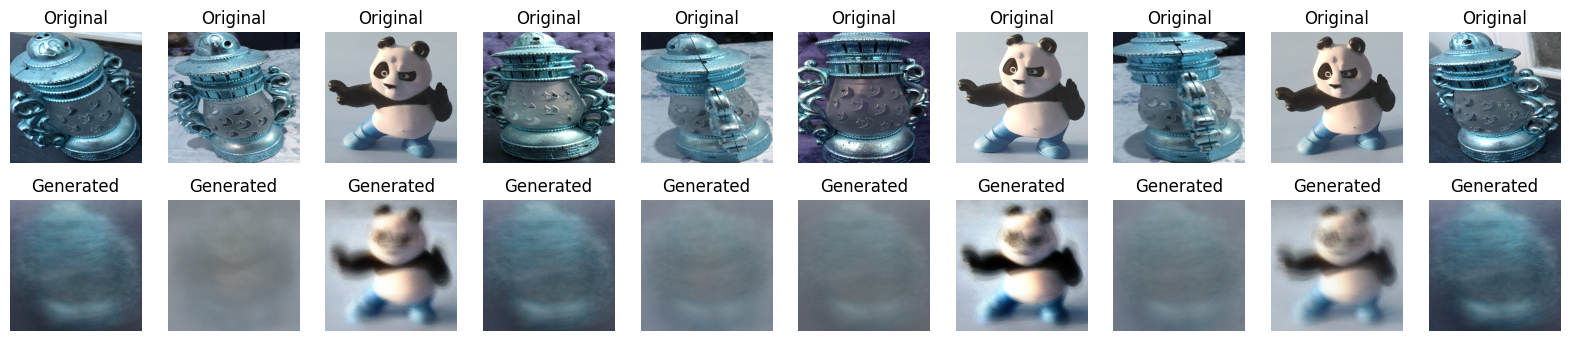

In [ ]:
# Display the original and reconstructed images for the first few samples
n = 10
plt.figure(figsize=(2 * n, 4))
for i in range(n):
    # Display original images
    plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(224, 224, 3))
    plt.axis('off')
    plt.title("Original")

    # Display reconstructed images from the sampled latent space
    plt.subplot(2, n, i + n + 1)
    reconstructed_image = decoded_random_sample[i].reshape(224, 224, 3)
    plt.imshow(reconstructed_image)
    plt.axis('off')
    plt.title("Generated")

plt.show()


In [ ]:
decoded_imgs = vae.predict(X_test)

2/2 [==============================] - 0s 11ms/step


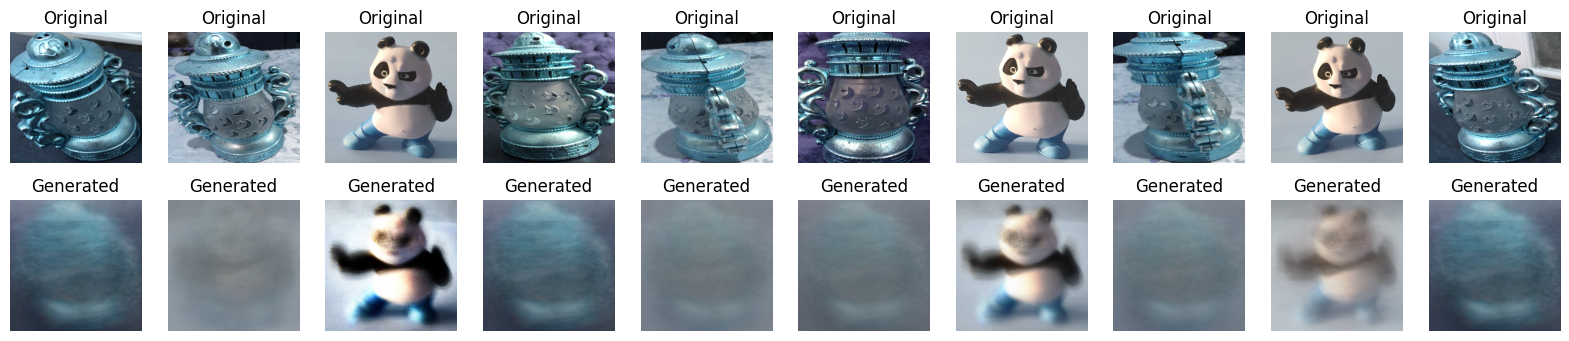

In [ ]:
# Display the original and reconstructed images for the first few samples
n = 10
plt.figure(figsize=(2 * n, 4))
for i in range(n):
    # Display original images
    plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(224, 224, 3))
    plt.axis('off')
    plt.title("Original")

    # Display reconstructed images from the sampled latent space
    plt.subplot(2, n, i + n + 1)
    reconstructed_image = decoded_imgs[i].reshape(224, 224, 3)
    plt.imshow(reconstructed_image)
    plt.axis('off')
    plt.title("Generated")

plt.show()


In [ ]:
class_names = ["Fanos","Panda"]

# CVAE

In [ ]:
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Define the input shape for colored images
original_dim = 224 * 224 * 3
intermediate_dim = 500  # Adjust based on your preferences
latent_dim = 30
num_classes = 2  # Adjust based on the number of classes/labels

# Define input layers
image_inputs = keras.Input(shape=(original_dim,), name='image_inputs')
label_inputs = keras.Input(shape=(num_classes,), name='label_inputs')

# Concatenate image and label inputs
concatenated_inputs = layers.concatenate([image_inputs, label_inputs])

# Encoder
h = layers.Dense(intermediate_dim, activation='relu')(concatenated_inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

# Sampling function with conditioning on label
def sampling(args):
    z_mean, z_log_sigma, label = args
    epsilon = keras.backend.random_normal(shape=(keras.backend.shape(z_mean)[0], latent_dim),
                                          mean=0., stddev=0.1)
    return z_mean + keras.backend.exp(z_log_sigma) * epsilon

# Lambda layer for sampling
z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma, label_inputs])
encoder = keras.Model([image_inputs, label_inputs], [z_mean, z_log_sigma, z], name='encoder')

# Decoder layers
decoder_h = layers.Dense(intermediate_dim, activation='relu')
decoder_mean = layers.Dense(original_dim, activation='sigmoid')

# Apply decoder layers to sampled latent space and label
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# Decoder model
decoder_input = layers.Input(shape=(latent_dim,))
label_decoder_input = layers.Input(shape=(num_classes,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
decoder = keras.Model([decoder_input, label_decoder_input], _x_decoded_mean, name='decoder')

# Instantiate VAE model
vae = keras.Model([image_inputs, label_inputs], x_decoded_mean)

# Define the VAE loss function
reconstruction_loss = keras.losses.mean_squared_error(image_inputs, x_decoded_mean)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - keras.backend.square(z_mean) - keras.backend.exp(z_log_sigma)
kl_loss = keras.backend.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = keras.backend.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.00001)  # Adjust the learning rate
vae.compile(optimizer=optimizer)

# Train the CVAE
# Assuming you have X_train, y_train, X_test, y_test for images and labels
# X_train = X_train.astype('float32') / 255.
# X_test = X_test.astype('float32') / 255.
y_train_one_hot = keras.utils.to_categorical(y_train_combined, num_classes=num_classes)
y_test_one_hot = keras.utils.to_categorical(y_test, num_classes=num_classes)

# Flatten the images for input to the model
X_train_flat = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test_flat = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

# Train the CVAE
vae.fit([X_train_flat, y_train_one_hot], epochs=100, batch_size=5, validation_data=([X_test_flat, y_test_one_hot], None))

Epoch 1/100
71/71 [==============================] - 5s 45ms/step - loss: 8928.0283 - val_loss: 8613.5771
Epoch 2/100
71/71 [==============================] - 3s 43ms/step - loss: 8136.9541 - val_loss: 7671.7134
Epoch 3/100
71/71 [==============================] - 3s 44ms/step - loss: 7439.8730 - val_loss: 6977.4102
Epoch 4/100
71/71 [==============================] - 3s 45ms/step - loss: 6991.0815 - val_loss: 6574.2012
Epoch 5/100
71/71 [==============================] - 3s 43ms/step - loss: 6735.5298 - val_loss: 6371.7080
Epoch 6/100
71/71 [==============================] - 3s 43ms/step - loss: 6550.9692 - val_loss: 6209.8872
Epoch 7/100
71/71 [==============================] - 3s 43ms/step - loss: 6387.6362 - val_loss: 6088.3911
Epoch 8/100
71/71 [==============================] - 3s 44ms/step - loss: 6250.5967 - val_loss: 6004.0732
Epoch 9/100
71/71 [==============================] - 3s 45ms/step - loss: 6125.7271 - val_loss: 5892.0342
Epoch 10/100
71/71 [==========================

In [ ]:
m, v, z = encoder.predict([X_test_flat, y_test_one_hot])

2/2 [==============================] - 0s 7ms/step


Enter the class index (0 or 1): 0


1/1 [==============================] - 0s 93ms/step


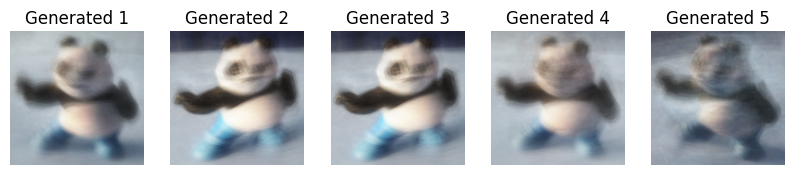

In [ ]:
# Prompt user for class input
label_index = int(input("Enter the class index (0 or 1): "))
label_one_hot = keras.utils.to_categorical(label_index, num_classes=num_classes)

# Filter samples from the specified class
class_indices = np.where(np.argmax(y_test_one_hot, axis=1) == label_index)[0]

# Choose 5 random samples from the specified class
random_sample_indices = np.random.choice(class_indices, size=5)
random_samples = sampling([m[random_sample_indices], v[random_sample_indices], label_one_hot])

# Repeat the label for the samples
label_one_hot_repeated = np.array([label_one_hot] * 5)

# Decode the random samples
decoded_random_samples = decoder.predict([random_samples, label_one_hot_repeated])

# Display the original and reconstructed images
plt.figure(figsize=(10, 4))

for i in range(5):
    # Display original image (optional, uncomment if needed)
    # plt.subplot(2, 5, i + 1)
    # plt.imshow(X_test[random_sample_indices[i]].reshape(224, 224, 3))
    # plt.axis('off')
    # plt.title("Original")

    # Display reconstructed images from the sampled latent space
    plt.subplot(2, 5, i + 6)
    reconstructed_image = decoded_random_samples[i].reshape(224, 224, 3)
    plt.imshow(reconstructed_image)
    plt.axis('off')
    plt.title("Generated {}".format(i + 1))

plt.show()


Enter the class index (0 or 1): 1
1/1 [==============================] - 0s 20ms/step


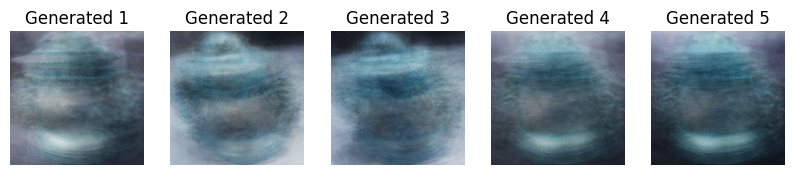

In [ ]:

# Prompt user for class input
label_index = int(input("Enter the class index (0 or 1): "))
label_one_hot = keras.utils.to_categorical(label_index, num_classes=num_classes)

# Filter samples from the specified class
class_indices = np.where(np.argmax(y_test_one_hot, axis=1) == label_index)[0]

# Choose 5 random samples from the specified class
random_sample_indices = np.random.choice(class_indices, size=5)
random_samples = m[random_sample_indices] + np.exp(0.5 * v[random_sample_indices]) * np.random.normal(size=(5, latent_dim))

# Repeat the label for the samples
label_one_hot_repeated = np.array([label_one_hot] * 5)

# Decode the random samples
decoded_random_samples = decoder.predict([random_samples, label_one_hot_repeated])

# Display the original and reconstructed images
plt.figure(figsize=(10, 4))

for i in range(5):
    # Display original image (optional, uncomment if needed)
    # plt.subplot(2, 5, i + 1)
    # plt.imshow(X_test[random_sample_indices[i]].reshape(224, 224, 3))
    # plt.axis('off')
    # plt.title("Original")

    # Display reconstructed images from the sampled latent space
    plt.subplot(2, 5, i + 6)
    reconstructed_image = decoded_random_samples[i].reshape(224, 224, 3)
    plt.imshow(reconstructed_image)
    plt.axis('off')
    plt.title("Generated {}".format(i + 1))

plt.show()


In [ ]:
# Install ipywidgets (if not already installed)
!pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.0 MB/s eta 0:00:00


In [ ]:


# ... (your existing code)

# Prompt user for class input
label_index = int(input("Enter the class index (0 or 1): "))
label_one_hot = keras.utils.to_categorical(label_index, num_classes=num_classes)

# Define a slider widget
num_images_slider = widgets.IntSlider(value=5, min=1, max=10, step=1, description='Num Images')

# Define a function to generate and display images based on the slider value
def generate_and_display_images(num_images):
    # Filter samples from the specified class
    class_indices = np.where(np.argmax(y_test_one_hot, axis=1) == label_index)[0]

    # Choose random samples from the specified class
    random_sample_indices = np.random.choice(class_indices, size=num_images)
    random_samples = m[random_sample_indices] + np.exp(0.5 * v[random_sample_indices]) * np.random.normal(size=(num_images, latent_dim))

    # Repeat the label for the samples
    label_one_hot_repeated = np.array([label_one_hot] * num_images)

    # Decode the random samples
    decoded_random_samples = decoder.predict([random_samples, label_one_hot_repeated])

    # Display the original and reconstructed images
    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        reconstructed_image = decoded_random_samples[i].reshape(224, 224, 3)
        plt.imshow(reconstructed_image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Display the slider and link it to the function
widgets.interactive(generate_and_display_images, num_images=num_images_slider)


Enter the class index (0 or 1): 0


interactive(children=(IntSlider(value=5, description='Num Images', max=10, min=1), Output()), _dom_classes=('w…

In [ ]:
# Prompt user for class input as string
label_input_str = input("Enter the class label (e.g., 'panda' or 'Fanos'): ")

# Map the string label to numerical label
class_mapping = {'panda': 0, 'Fanos': 1}
if label_input_str.lower() in class_mapping:
    label_index = class_mapping[label_input_str.lower()]
    label_one_hot = keras.utils.to_categorical(label_index, num_classes=num_classes)
else:
    print("Invalid class label. Please enter 'panda' or 'Fanos'.")
    exit()

# Define a slider widget for the number of images
num_images_slider = widgets.IntSlider(value=5, min=1, max=10, step=1, description='Num Images')

# Define a function to generate and display images based on the slider value
def generate_and_display_images(num_images):
    # Filter samples from the specified class
    class_indices = np.where(np.argmax(y_test_one_hot, axis=1) == label_index)[0]

    # Choose random samples from the specified class
    random_sample_indices = np.random.choice(class_indices, size=num_images)
    random_samples = m[random_sample_indices] + np.exp(0.5 * v[random_sample_indices]) * np.random.normal(size=(num_images, latent_dim))

    # Repeat the label for the samples
    label_one_hot_repeated = np.array([label_one_hot] * num_images)

    # Decode the random samples
    decoded_random_samples = decoder.predict([random_samples, label_one_hot_repeated])

    # Display the original and reconstructed images
    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        reconstructed_image = decoded_random_samples[i].reshape(224, 224, 3)
        plt.imshow(reconstructed_image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Display the widgets and link them to the function
widgets.interactive(generate_and_display_images, num_images=num_images_slider)


Enter the class label (e.g., 'panda' or 'rabbit'): Fanos
Invalid class label. Please enter 'panda' or 'rabbit'.


interactive(children=(IntSlider(value=5, description='Num Images', max=10, min=1), Output()), _dom_classes=('w…